# Predictive models

Given a repository of customer information, sales call records, and purchase history, machine learning algorithms are created to predict B2B customer conversion and expected revenue

### Packages used

In [319]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import pickle
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV


## Data Exploration

In [320]:
df = pd.read_csv('df_training_scholarjet.csv')

In [321]:
print('Number of samples:',len(df))

Number of samples: 28126


In [322]:
print('Number of columns:',len(df.columns))

Number of columns: 184


In [323]:
correlation = df.corr().abs()
correlation.to_csv('correlation.csv')

# Classification

## Feature Engineering

In [324]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return (sum(y_actual)/len(y_actual))

In [325]:
print('prevalence of the positive class: %.3f'%calc_prevalence(df['convert_30'].values))

prevalence of the positive class: 0.104


In [326]:
# for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

Unnamed: 0: 28126 unique values
cuid: 28126 unique values
convert_30
[0 1]
revenue_30: 2549 unique values
roll_up
['Onboarding' 'Retention' 'Unmanaged']
currentstatus
['Active' 'Enrolled' 'In Progress' 'Unconfirmed']
companytypegroup
['Business' 'Trade']
team
['US' 'CA']
customersource
['External Application' 'Internal Application' 'Internal Customer Scrape'
 'Gateway' 'Social - Paid' 'Search - Paid' 'Other' 'Quotes' 'Affiliates'
 'Referral' 'Bulk Upload' 'Email' 'Display - Retargeting'
 'Display - Acquisition' 'Self ID' 'Partners']
accrole
['None' 'Primary' 'Purchaser' 'Other']
num_employees
['50plus' '2to5' '1' '6to10' 'None' '11to50']
num_purchases_year
['1to2' '25plus' '3to5' '11to25' 'None' '6to10']
cost_purchases_year
['lessthan1' '25to100' '1to5' '5to25' 'None' '100plus']
enrollmentmethod
['directEIN' 'email' 'other' 'phone' 'liveTransfer' 'directOther']
numorderone
[ 0. nan  1.  3.  2.]
numorderthreeone
[ 0. nan  1.  4.  2.  3.]
numorderseventhree
[ 0. nan  1.  2.  3.  4.  5.]


In [327]:
# replace ? with nan
df = df.replace('?',np.nan)

In [328]:
#all the numerical columns
cols_num = ['numorderone',
            'numorderthreeone',
            'numorderseventhree',
            'numorderthirtyseven',
            'numordersixtythirty',
            'numorderyearsixty',
            'sumrevone',
            'sumrevthreeone',
            'sumrevseventhree',
             'sumrevthirtyseven',
             'sumrevsixtythirty',
             'sumrevyearsixty',
             'numbamorder',
             'numselforder',
             'totalrev',
             'aov',
             'dayssincelastord',
             'cuidshare',
             'numstores',
             'pospercentage',
             'numinf',
             'numinfconnect',
             'numinfphone',
             'numinfquote',
             'percentlarge',
             'percdirtythirty',
             'percdirtyninetythirty',
             'percdirtyyearninety',
             'numbilling',
             'numreturn',
             'numwims',
             'numproblem',
             'numother',
             'percentresolved',
             'minnps',
             'avgnps',
             'maxnps',
             'nps_count',
             'numquote',
             'numorderfromquote',
             'quoteconrate',
             'avgquoteprice',
             'avgconquoteprice',
             'numvisitone',
             'numvisitthreeone',
             'numvisitseventhree',
             'numvisitthirtyseven',
             'numvisitsixtythirty',
             'numvisityearsixty',
             'numvisittotal',
             'numloggedinone',
             'numloggedinthreeone',
             'numloggedinseventhree',
             'numloggedinthirtyseven',
             'numloggedinsixtythirty',
             'numloggedinyearsixty',
             'numsecondsonsiteone',
             'numsecondsonsitethreeone',
             'numsecondsonsiteseventhree',
             'numsecondsonsitethirtyseven',
             'numsecondsonsitesixtythirty',
             'numsecondsonsiteyearsixty',
             'numtotalpageviewsone',
             'numtotalpageviewsthreeone',
             'numtotalpageviewsseventhree',
             'numtotalpageviewsthirtyseven',
             'numtotalpageviewssixtythirty',
             'numtotalpageviewsyearsixty',
             'numatcone',
             'numatcthreeone',
             'numatcseventhree',
             'numatcthirtyseven',
             'numatcsixtythirty',
             'numatcyearsixty',
             'numideaboardone',
             'numideaboardthreeone',
             'numideaboardseventhree',
             'numideaboardthirtyseven',
             'numideaboardsixtythirty',
             'numideaboardyearsixty',
             'dayssincelastvisit',
             'sumatcprice',
             'avgatcprice',
             'numsearchtermsone',
             'numsearchtermsthreeone',
             'numsearchtermsseventhree',
             'numsearchtermsthirtyseven',
             'numsearchtermssixtythirty',
             'numsearchtermsyearsixty',
             'numskusviewedone',
             'numskusviewedthreeone',
             'numskusviewedseventhree',
             'numskusviewedthirtyseven',
             'numskusviewedsixtythirty',
             'numskusviewedyearsixty',
             'avgpriceone',
             'avgpricethreeone',
             'avgpriceseventhree',
             'avgpricethirtyseven',
             'avgpricesixtythirty',
             'avgpriceyearsixty',
             'avgprice',
             'numtasksfirstintroone',
             'numtasksfirstintrothreeone',
             'numtasksfirstintroseventhree',
             'numtasksfirstintrothirtyseven',
             'numtasksfirstintrosixtythirty',
             'numtasksfirstintroyearsixty',
             'numtaskscadenceone',
             'numtaskscadencethreeone',
             'numtaskscadenceseventhree',
             'numtaskscadencethirtyseven',
             'numtaskscadencesixtythirty',
             'numtaskscadenceyearsixty',
             'numtasksreassignthreeone',
             'numtasksreassignseventhree',
             'numtasksreassignthirtyseven',
             'numtasksreassignsixtythirty',
             'numtasksreassignyearsixty',
             'numtaskscustactone',
             'numtaskscustactthreeone',
             'numtaskscustactseventhree',
             'numtaskscustactthirtyseven',
             'numtaskscustactsixtythirty',
             'numtaskscustactyearsixty',
             'numcallsone',
             'numcallsthreeone',
             'numcallsseventhree',
             'numcallsthirtyseven',
             'numcallssixtythirty',
             'numcallsyearsixty',
             'numemailsone',
             'numemailsthreeone',
             'numemailsseventhree',
             'numemailsthirtyseven',
             'numemailssixtythirty',
             'numemailsyearsixty',
             'totalcalldurationone',
             'totalcalldurationthreeone',
             'totalcalldurationseventhree',
             'totalcalldurationthirtyseven',
             'totalcalldurationsixtythirty',
             'totalcalldurationyearsixty',
             'percsecondsinbound',
             'percemailopenedone',
             'percemailopenedthreeone',
             'percemailopenedseventhree',
             'percemailopenedthirtyseven',
             'percemailopenedsixtythirty',
             'percemailopenedyearsixty',
             'percemailclickedone',
             'percemailclickedthreeone',
             'percemailclickedseventhree',
             'percemailclickedthirtyseven',
             'percemailclickedsixtythirty',
             'percemailclickedyearsixty',
             'currentapplicability',
             'numemaillist',
             'dayssinceenrollment']

In [329]:
#finding the number of null records
df[cols_num].isnull().sum()

numorderone                     18424
numorderthreeone                18424
numorderseventhree              18424
numorderthirtyseven             18424
numordersixtythirty             18424
numorderyearsixty               18424
sumrevone                       18424
sumrevthreeone                  18424
sumrevseventhree                18424
sumrevthirtyseven               18426
sumrevsixtythirty               18425
sumrevyearsixty                 18426
numbamorder                     18424
numselforder                    18424
totalrev                        18429
aov                             18429
dayssincelastord                    0
cuidshare                       18424
numstores                       18424
pospercentage                   18429
numinf                          18429
numinfconnect                   18429
numinfphone                     18429
numinfquote                     18429
percentlarge                    18424
percdirtythirty                 18424
percdirtynin

In [330]:
#all the categorical columns
cols_cat = ['roll_up', 'currentstatus', 'companytypegroup','team', 'customersource','accrole', 'num_employees',
            'num_purchases_year', 'cost_purchases_year', 'enrollmentmethod']

In [331]:
#finding the number of null records
df[cols_cat].isnull().sum()

roll_up                0
currentstatus          0
companytypegroup       0
team                   0
customersource         0
accrole                0
num_employees          0
num_purchases_year     0
cost_purchases_year    0
enrollmentmethod       0
dtype: int64

In [332]:
#one hot coding : To convert categorical
df_cat = pd.get_dummies(df[cols_cat],drop_first = True)
df_cat.head()

,roll_up_Retention,roll_up_Unmanaged,currentstatus_Enrolled,currentstatus_In Progress,currentstatus_Unconfirmed,companytypegroup_Trade,team_US,customersource_Bulk Upload,customersource_Display - Acquisition,customersource_Display - Retargeting,...,cost_purchases_year_1to5,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [333]:
df = pd.concat([df,df_cat], axis = 1)

In [334]:
cols_all_cat = list(df_cat.columns)

In [335]:
print('Total number of features:', len(cols_num + cols_all_cat))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))

Total number of features: 204
Numerical Features: 159
Categorical Features: 45


In [336]:
df[cols_num + cols_all_cat].isnull().sum().sort_values(ascending = False).head(10)

avgconquoteprice     27351
avgquoteprice        26555
numquote             26555
quoteconrate         26555
numorderfromquote    26555
minnps               26415
avgnps               26415
maxnps               26415
nps_count            26415
avgpriceone          25718
dtype: int64

In [337]:
#new dataframe for creating model
cols_input = cols_num + cols_all_cat
df_data = df[cols_input + ['convert_30']]
df_data.head()

,numorderone,numorderthreeone,numorderseventhree,numorderthirtyseven,numordersixtythirty,numorderyearsixty,sumrevone,sumrevthreeone,sumrevseventhree,sumrevthirtyseven,...,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone,convert_30
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,59.99,...,0,0,0,1,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,...,1,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,237.98,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0


### Training and Validation Set

In [338]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

In [339]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [340]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

In [341]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

In [342]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.convert_30.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.convert_30.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.convert_30.values)))

Test prevalence(n = 4219):0.106
Valid prevalence(n = 4219):0.103
Train all prevalence(n = 19688):0.104


In [343]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 28126)


In [344]:
# split the training data into positive and negative
rows_pos = df_train_all.convert_30 == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.convert_30.values)))

Train balanced prevalence(n = 4092):0.500


In [345]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [346]:
pickle.dump(cols_input, open('cols_input.sav', 'wb'))

In [347]:
def fill_my_missing(df, df_mean, col2use):
    # This function fills the missing values

    # check the columns are present
    for c in col2use:
        assert c in df.columns, c + ' not in df'
        assert c in df_mean.col.values, c+ 'not in df_mean'
    
    # replace the mean 
    for c in col2use:
        mean_value = df_mean.loc[df_mean.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

In [348]:
df_mean = df_train_all[cols_input].mean(axis = 0)
# save the means
df_mean.to_csv('df_mean.csv',index=True)

In [349]:
# load the means so we know how to do it for the test data
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
df_mean_in.head()

,col,mean_val
0,numorderone,0.020806
1,numorderthreeone,0.037922
2,numorderseventhree,0.076583
3,numorderthirtyseven,0.341154
4,numordersixtythirty,0.342629


In [350]:
df_train_all = fill_my_missing(df_train_all, df_mean_in, cols_input)
df_train = fill_my_missing(df_train, df_mean_in, cols_input)
df_valid = fill_my_missing(df_valid, df_mean_in, cols_input)

In [351]:
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train['convert_30'].values
y_valid = df_valid['convert_30'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (19688, 204)
Training shapes: (4092, 204) (4092,)
Validation shapes: (4219, 204) (4219,)


In [352]:
scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [353]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [354]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [355]:
# transform our data matrices
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

## Model Selection

In [356]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

thresh = 0.5

#### KNN 

In [357]:
# k-nearest neighbors
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=100, p=2,
           weights='uniform')

In [358]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.768
accuracy:0.650
recall:0.385
precision:0.821
specificity:0.911
prevalence:0.500
 
Validation:
AUC:0.744
accuracy:0.861
recall:0.353
precision:0.333
specificity:0.912
prevalence:0.103
 


#### Linear Regression 

In [359]:
t1 = time.time()
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.617351770401001


In [360]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.818
accuracy:0.728
recall:0.688
precision:0.749
specificity:0.769
prevalence:0.500
 
Validation:
AUC:0.771
accuracy:0.731
recall:0.659
precision:0.225
specificity:0.740
prevalence:0.103
 


#### Stochastic Gradient Descent 

In [361]:
t1 = time.time()
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

0.03390622138977051


C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [362]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.810
accuracy:0.721
recall:0.661
precision:0.752
specificity:0.782
prevalence:0.500
 
Validation:
AUC:0.780
accuracy:0.761
recall:0.629
precision:0.244
specificity:0.776
prevalence:0.103
 


#### Naive Bayes 

In [363]:
nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [364]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.765
accuracy:0.664
recall:0.461
precision:0.775
specificity:0.866
prevalence:0.500
 
Validation:
AUC:0.748
accuracy:0.817
recall:0.454
precision:0.270
specificity:0.859
prevalence:0.103
 


#### Decision Tree Classifier

In [365]:
tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [366]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.943
accuracy:0.868
recall:0.856
precision:0.876
specificity:0.878
prevalence:0.500
 
Validation:
AUC:0.718
accuracy:0.700
recall:0.705
precision:0.212
specificity:0.699
prevalence:0.103
 


#### Random Forest

In [367]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [368]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.845
accuracy:0.758
recall:0.753
precision:0.761
specificity:0.764
prevalence:0.500
 
Validation:
AUC:0.805
accuracy:0.734
recall:0.721
precision:0.238
specificity:0.735
prevalence:0.103
 


#### Gradient Boosting Classifier

In [369]:
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [370]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.990
accuracy:0.957
recall:0.947
precision:0.966
specificity:0.966
prevalence:0.500
 
Validation:
AUC:0.740
accuracy:0.673
recall:0.666
precision:0.190
specificity:0.674
prevalence:0.103
 


### Plot the ROC

In [371]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_train_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_train_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_train_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_train_precision,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_train_specificity,gbc_valid_specificity,]})

In [372]:
sns.set(style="darkgrid")

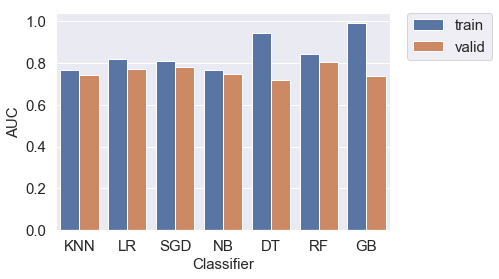

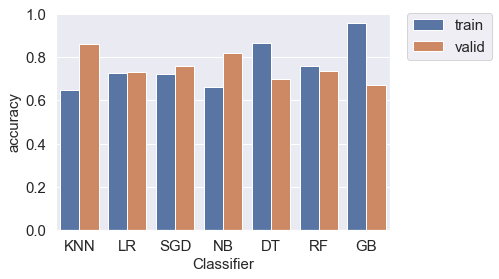

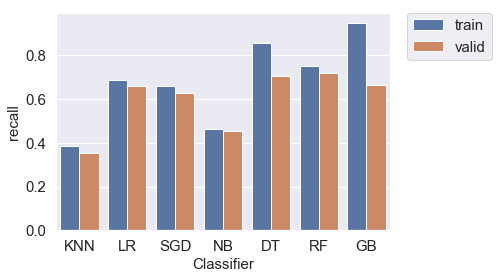

In [373]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('accuracy', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

ax = sns.barplot(x="classifier", y="recall", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('recall', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

Optimizing Stochastic Gradient Descent and Random Forest classification model

Optimzing Random Forest

In [374]:
# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(2,20,2)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(2, 20, 2), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [375]:
auc_scoring = make_scorer(roc_auc_score)

In [376]:
# create a baseline model
rf = RandomForestClassifier()

# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, 
                               scoring=auc_scoring,verbose = 1, random_state = 42)

In [377]:
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.7min finished


110.73053193092346


In [378]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 4,
 'max_features': 'sqrt',
 'max_depth': 12,
 'criterion': 'entropy'}

In [379]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline Random Forest')
rf_train_base_auc = roc_auc_score(y_train, y_train_preds)
rf_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(rf_train_base_auc))
print('Validation AUC:%.3f'%(rf_valid_base_auc))

print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(rf_train_opt_auc))
print('Validation AUC:%.3f'%(rf_valid_opt_auc))

C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Baseline Random Forest
Training AUC:0.845
Validation AUC:0.805
Optimized Random Forest
Training AUC:0.971
Validation AUC:0.817


Optimizing Stochastic Gradient Descent

In [380]:
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.1, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [381]:
penalty = ['none','l2','l1']
max_iter = range(200,1000,200)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, random_state = 42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassif

C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


47.21642351150513


In [382]:
sgdc_random.best_params_

{'penalty': 'l1', 'max_iter': 800, 'alpha': 0.03}

In [383]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline sgdc')
sgdc_train_base_auc = roc_auc_score(y_train, y_train_preds)
sgdc_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:%.3f'%(sgdc_train_base_auc))
print('Validation AUC:%.3f'%(sgdc_valid_base_auc))

print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training AUC:%.3f'%(sgdc_train_opt_auc))
print('Validation AUC:%.3f'%(sgdc_valid_opt_auc))

Baseline sgdc
Training AUC:0.810
Validation AUC:0.780
Optimized sgdc
Training AUC:0.789
Validation AUC:0.781


In [384]:
df_results = pd.DataFrame({'classifier':['SGD','SGD','RF','RF'],
                           'data_set':['baseline','optimized']*2,
                          'auc Validation':[sgdc_valid_base_auc,sgdc_valid_opt_auc,
                                 rf_valid_base_auc,rf_valid_opt_auc],
                           'auc Training':[sgdc_train_base_auc,sgdc_train_opt_auc,
                                 rf_train_base_auc,rf_train_opt_auc],
                          })

In [385]:
df_results

,classifier,data_set,auc Validation,auc Training
0,SGD,baseline,0.780358,0.809917
1,SGD,optimized,0.780902,0.789404
2,RF,baseline,0.805314,0.844638
3,RF,optimized,0.816631,0.971078


In [386]:
#Choosing the Model
pickle.dump(rf, open('best_classifier.pkl', 'wb'),protocol = 4)

### Model Evaluation

In [387]:
# load the model, columns, mean values, and scaler
best_model = pickle.load(open('best_classifier.pkl','rb'))
cols_input = pickle.load(open('cols_input.sav','rb'))
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
scaler = pickle.load(open('scaler.sav', 'rb'))

In [388]:
# load the data
df_train = pd.read_csv('df_train.csv')
df_valid= pd.read_csv('df_valid.csv')
df_test= pd.read_csv('df_test.csv')

In [389]:
# fill missing
df_train = fill_my_missing(df_train, df_mean_in, cols_input)
df_valid = fill_my_missing(df_valid, df_mean_in, cols_input)
df_test = fill_my_missing(df_test, df_mean_in, cols_input)

# create X and y matrices
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

y_train = df_train['convert_30'].values
y_valid = df_valid['convert_30'].values
y_test = df_test['convert_30'].values

# transform our data matrices 
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

In [390]:
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [391]:
thresh = 0.5

print('Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,y_valid_preds, thresh)
print('Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,y_test_preds, thresh)

Training:
AUC:0.845
accuracy:0.758
recall:0.753
precision:0.761
specificity:0.764
prevalence:0.500
 
Validation:
AUC:0.805
accuracy:0.734
recall:0.721
precision:0.238
specificity:0.735
prevalence:0.103
 
Test:
AUC:0.793
accuracy:0.720
recall:0.723
precision:0.234
specificity:0.719
prevalence:0.106
 


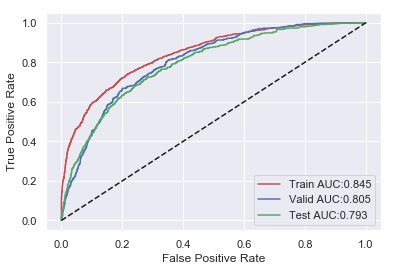

In [392]:
#ROC Curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-',label ='Test AUC:%.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Predecting Convert_30 - Conversion of the customer

In [393]:
df_hold= pd.read_csv('df_holdout_scholarjet.csv')

In [394]:
# replace ? with nan
df_hold = df_hold.replace('?',np.nan)

In [395]:
cols_num_hold = ['numorderone',
            'numorderthreeone',
            'numorderseventhree',
            'numorderthirtyseven',
            'numordersixtythirty',
            'numorderyearsixty',
            'sumrevone',
            'sumrevthreeone',
            'sumrevseventhree',
             'sumrevthirtyseven',
             'sumrevsixtythirty',
             'sumrevyearsixty',
             'numbamorder',
             'numselforder',
             'totalrev',
             'aov',
             'dayssincelastord',
             'cuidshare',
             'numstores',
             'pospercentage',
             'numinf',
             'numinfconnect',
             'numinfphone',
             'numinfquote',
             'percentlarge',
             'percdirtythirty',
             'percdirtyninetythirty',
             'percdirtyyearninety',
             'numbilling',
             'numreturn',
             'numwims',
             'numproblem',
             'numother',
             'percentresolved',
             'minnps',
             'avgnps',
             'maxnps',
             'nps_count',
             'numquote',
             'numorderfromquote',
             'quoteconrate',
             'avgquoteprice',
             'avgconquoteprice',
             'numvisitone',
             'numvisitthreeone',
             'numvisitseventhree',
             'numvisitthirtyseven',
             'numvisitsixtythirty',
             'numvisityearsixty',
             'numvisittotal',
             'numloggedinone',
             'numloggedinthreeone',
             'numloggedinseventhree',
             'numloggedinthirtyseven',
             'numloggedinsixtythirty',
             'numloggedinyearsixty',
             'numsecondsonsiteone',
             'numsecondsonsitethreeone',
             'numsecondsonsiteseventhree',
             'numsecondsonsitethirtyseven',
             'numsecondsonsitesixtythirty',
             'numsecondsonsiteyearsixty',
             'numtotalpageviewsone',
             'numtotalpageviewsthreeone',
             'numtotalpageviewsseventhree',
             'numtotalpageviewsthirtyseven',
             'numtotalpageviewssixtythirty',
             'numtotalpageviewsyearsixty',
             'numatcone',
             'numatcthreeone',
             'numatcseventhree',
             'numatcthirtyseven',
             'numatcsixtythirty',
             'numatcyearsixty',
             'numideaboardone',
             'numideaboardthreeone',
             'numideaboardseventhree',
             'numideaboardthirtyseven',
             'numideaboardsixtythirty',
             'numideaboardyearsixty',
             'dayssincelastvisit',
             'sumatcprice',
             'avgatcprice',
             'numsearchtermsone',
             'numsearchtermsthreeone',
             'numsearchtermsseventhree',
             'numsearchtermsthirtyseven',
             'numsearchtermssixtythirty',
             'numsearchtermsyearsixty',
             'numskusviewedone',
             'numskusviewedthreeone',
             'numskusviewedseventhree',
             'numskusviewedthirtyseven',
             'numskusviewedsixtythirty',
             'numskusviewedyearsixty',
             'avgpriceone',
             'avgpricethreeone',
             'avgpriceseventhree',
             'avgpricethirtyseven',
             'avgpricesixtythirty',
             'avgpriceyearsixty',
             'avgprice',
             'numtasksfirstintroone',
             'numtasksfirstintrothreeone',
             'numtasksfirstintroseventhree',
             'numtasksfirstintrothirtyseven',
             'numtasksfirstintrosixtythirty',
             'numtasksfirstintroyearsixty',
             'numtaskscadenceone',
             'numtaskscadencethreeone',
             'numtaskscadenceseventhree',
             'numtaskscadencethirtyseven',
             'numtaskscadencesixtythirty',
             'numtaskscadenceyearsixty',
             'numtasksreassignthreeone',
             'numtasksreassignseventhree',
             'numtasksreassignthirtyseven',
             'numtasksreassignsixtythirty',
             'numtasksreassignyearsixty',
             'numtaskscustactone',
             'numtaskscustactthreeone',
             'numtaskscustactseventhree',
             'numtaskscustactthirtyseven',
             'numtaskscustactsixtythirty',
             'numtaskscustactyearsixty',
             'numcallsone',
             'numcallsthreeone',
             'numcallsseventhree',
             'numcallsthirtyseven',
             'numcallssixtythirty',
             'numcallsyearsixty',
             'numemailsone',
             'numemailsthreeone',
             'numemailsseventhree',
             'numemailsthirtyseven',
             'numemailssixtythirty',
             'numemailsyearsixty',
             'totalcalldurationone',
             'totalcalldurationthreeone',
             'totalcalldurationseventhree',
             'totalcalldurationthirtyseven',
             'totalcalldurationsixtythirty',
             'totalcalldurationyearsixty',
             'percsecondsinbound',
             'percemailopenedone',
             'percemailopenedthreeone',
             'percemailopenedseventhree',
             'percemailopenedthirtyseven',
             'percemailopenedsixtythirty',
             'percemailopenedyearsixty',
             'percemailclickedone',
             'percemailclickedthreeone',
             'percemailclickedseventhree',
             'percemailclickedthirtyseven',
             'percemailclickedsixtythirty',
             'percemailclickedyearsixty',
             'currentapplicability',
             'numemaillist',
             'dayssinceenrollment']

In [396]:
df_hold[cols_num_hold].isnull().sum()

numorderone                     17641
numorderthreeone                17641
numorderseventhree              17641
numorderthirtyseven             17641
numordersixtythirty             17641
numorderyearsixty               17641
sumrevone                       17641
sumrevthreeone                  17641
sumrevseventhree                17641
sumrevthirtyseven               17642
sumrevsixtythirty               17642
sumrevyearsixty                 17647
numbamorder                     17641
numselforder                    17641
totalrev                        17649
aov                             17649
dayssincelastord                    0
cuidshare                       17641
numstores                       17641
pospercentage                   17649
numinf                          17649
numinfconnect                   17649
numinfphone                     17649
numinfquote                     17649
percentlarge                    17641
percdirtythirty                 17641
percdirtynin

In [397]:
cols_cat_hold = ['roll_up', 'currentstatus', 'companytypegroup','team', 'customersource','accrole', 'num_employees',
            'num_purchases_year', 'cost_purchases_year', 'enrollmentmethod']

In [398]:
df_hold[cols_cat_hold].isnull().sum()

roll_up                0
currentstatus          0
companytypegroup       0
team                   0
customersource         0
accrole                0
num_employees          0
num_purchases_year     0
cost_purchases_year    0
enrollmentmethod       0
dtype: int64

In [399]:
df_cat_hold = pd.get_dummies(df_hold[cols_cat_hold],drop_first = True)
df_cat_hold.head()

,roll_up_Retention,roll_up_Unmanaged,currentstatus_Enrolled,currentstatus_In Progress,currentstatus_Inactive,companytypegroup_Trade,team_US,customersource_Bulk Upload,customersource_Display - Acquisition,customersource_Display - Retargeting,...,cost_purchases_year_1to5,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,0,1,0,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [400]:
df_hold = pd.concat([df_hold,df_cat_hold], axis = 1)

In [401]:
cols_all_cat_hold = list(df_cat_hold.columns)

In [402]:
df_hold[cols_num_hold + cols_all_cat_hold].isnull().sum().sort_values(ascending = False).head(10)

avgconquoteprice     29231
avgpriceone          28669
numorderfromquote    28227
avgquoteprice        28227
quoteconrate         28227
numquote             28227
minnps               28123
avgnps               28123
maxnps               28123
nps_count            28123
dtype: int64

In [403]:
cols_input_hold = cols_num_hold + cols_all_cat_hold
df_data_hold = df_hold[cols_input_hold]

In [404]:
df_data_hold.to_csv('df_data_hold.csv',index=False)

In [405]:
pickle.dump(cols_input_hold, open('cols_input_hold.sav', 'wb'))

In [406]:
def fill_my_missing(df_hold, df_mean_hold, col2use):
    # This function fills the missing values

    # check the columns are present
    for c in col2use:
        assert c in df_hold.columns, c + ' not in df'
        assert c in df_mean_hold.col.values, c+ 'not in df_mean'
    
    # replace the mean 
    for c in col2use:
        mean_value = df_mean_hold.loc[df_mean_hold.col == c,'mean_val'].values[0]
        df_hold[c] = df_hold[c].fillna(mean_value)
    return df_hold

In [407]:
df_mean_hold = df_data_hold[cols_input_hold].mean(axis = 0)
# save the means
df_mean_hold.to_csv('df_mean_hold.csv',index=True)

In [408]:
# load the means so we know how to do it for the test data
df_mean_in_hold = pd.read_csv('df_mean_hold.csv', names =['col','mean_val'])
df_mean_in_hold.head()

,col,mean_val
0,numorderone,0.011308
1,numorderthreeone,0.029920
2,numorderseventhree,0.041150
3,numorderthirtyseven,0.258049
4,numordersixtythirty,0.311764


In [409]:
df_data_hold = fill_my_missing(df_data_hold, df_mean_in_hold, cols_input_hold)

C:\Users\raksh\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [410]:
X_data_hold = df_data_hold[cols_input_hold].values
scaler_hold = StandardScaler()
scaler_hold.fit(X_data_hold)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [411]:
scalerfile_hold = 'scaler.sav'
pickle.dump(scaler, open(scalerfile_hold, 'wb'))

In [412]:
# load it back
scaler_hold = pickle.load(open(scalerfile_hold, 'rb'))

In [413]:
X_data_hold = scaler_hold.transform(X_data_hold)

In [414]:
predicted_hold = best_model.predict(X_data_hold)
print(predicted_hold)

[0 1 1 ... 0 0 0]


In [416]:
np.savetxt("predicted_hold_classification.csv", predicted_hold , delimiter=" ", header = "predicted_convert_30", fmt ='%i')

# Regression

In [417]:
df = pd.read_csv('df_training_scholarjet.csv')

In [418]:
# replace ? with nan
df = df.replace('?',np.nan)

In [419]:
cols_num = ['numorderone',
            'numorderthreeone',
            'numorderseventhree',
            'numorderthirtyseven',
            'numordersixtythirty',
            'numorderyearsixty',
            'sumrevone',
            'sumrevthreeone',
            'sumrevseventhree',
             'sumrevthirtyseven',
             'sumrevsixtythirty',
             'sumrevyearsixty',
             'numbamorder',
             'numselforder',
             'totalrev',
             'aov',
             'dayssincelastord',
             'cuidshare',
             'numstores',
             'pospercentage',
             'numinf',
             'numinfconnect',
             'numinfphone',
             'numinfquote',
             'percentlarge',
             'percdirtythirty',
             'percdirtyninetythirty',
             'percdirtyyearninety',
             'numbilling',
             'numreturn',
             'numwims',
             'numproblem',
             'numother',
             'percentresolved',
             'minnps',
             'avgnps',
             'maxnps',
             'nps_count',
             'numquote',
             'numorderfromquote',
             'quoteconrate',
             'avgquoteprice',
             'avgconquoteprice',
             'numvisitone',
             'numvisitthreeone',
             'numvisitseventhree',
             'numvisitthirtyseven',
             'numvisitsixtythirty',
             'numvisityearsixty',
             'numvisittotal',
             'numloggedinone',
             'numloggedinthreeone',
             'numloggedinseventhree',
             'numloggedinthirtyseven',
             'numloggedinsixtythirty',
             'numloggedinyearsixty',
             'numsecondsonsiteone',
             'numsecondsonsitethreeone',
             'numsecondsonsiteseventhree',
             'numsecondsonsitethirtyseven',
             'numsecondsonsitesixtythirty',
             'numsecondsonsiteyearsixty',
             'numtotalpageviewsone',
             'numtotalpageviewsthreeone',
             'numtotalpageviewsseventhree',
             'numtotalpageviewsthirtyseven',
             'numtotalpageviewssixtythirty',
             'numtotalpageviewsyearsixty',
             'numatcone',
             'numatcthreeone',
             'numatcseventhree',
             'numatcthirtyseven',
             'numatcsixtythirty',
             'numatcyearsixty',
             'numideaboardone',
             'numideaboardthreeone',
             'numideaboardseventhree',
             'numideaboardthirtyseven',
             'numideaboardsixtythirty',
             'numideaboardyearsixty',
             'dayssincelastvisit',
             'sumatcprice',
             'avgatcprice',
             'numsearchtermsone',
             'numsearchtermsthreeone',
             'numsearchtermsseventhree',
             'numsearchtermsthirtyseven',
             'numsearchtermssixtythirty',
             'numsearchtermsyearsixty',
             'numskusviewedone',
             'numskusviewedthreeone',
             'numskusviewedseventhree',
             'numskusviewedthirtyseven',
             'numskusviewedsixtythirty',
             'numskusviewedyearsixty',
             'avgpriceone',
             'avgpricethreeone',
             'avgpriceseventhree',
             'avgpricethirtyseven',
             'avgpricesixtythirty',
             'avgpriceyearsixty',
             'avgprice',
             'numtasksfirstintroone',
             'numtasksfirstintrothreeone',
             'numtasksfirstintroseventhree',
             'numtasksfirstintrothirtyseven',
             'numtasksfirstintrosixtythirty',
             'numtasksfirstintroyearsixty',
             'numtaskscadenceone',
             'numtaskscadencethreeone',
             'numtaskscadenceseventhree',
             'numtaskscadencethirtyseven',
             'numtaskscadencesixtythirty',
             'numtaskscadenceyearsixty',
             'numtasksreassignthreeone',
             'numtasksreassignseventhree',
             'numtasksreassignthirtyseven',
             'numtasksreassignsixtythirty',
             'numtasksreassignyearsixty',
             'numtaskscustactone',
             'numtaskscustactthreeone',
             'numtaskscustactseventhree',
             'numtaskscustactthirtyseven',
             'numtaskscustactsixtythirty',
             'numtaskscustactyearsixty',
             'numcallsone',
             'numcallsthreeone',
             'numcallsseventhree',
             'numcallsthirtyseven',
             'numcallssixtythirty',
             'numcallsyearsixty',
             'numemailsone',
             'numemailsthreeone',
             'numemailsseventhree',
             'numemailsthirtyseven',
             'numemailssixtythirty',
             'numemailsyearsixty',
             'totalcalldurationone',
             'totalcalldurationthreeone',
             'totalcalldurationseventhree',
             'totalcalldurationthirtyseven',
             'totalcalldurationsixtythirty',
             'totalcalldurationyearsixty',
             'percsecondsinbound',
             'percemailopenedone',
             'percemailopenedthreeone',
             'percemailopenedseventhree',
             'percemailopenedthirtyseven',
             'percemailopenedsixtythirty',
             'percemailopenedyearsixty',
             'percemailclickedone',
             'percemailclickedthreeone',
             'percemailclickedseventhree',
             'percemailclickedthirtyseven',
             'percemailclickedsixtythirty',
             'percemailclickedyearsixty',
             'currentapplicability',
             'numemaillist',
             'dayssinceenrollment']

In [420]:
df[cols_num].isnull().sum()

numorderone                     18424
numorderthreeone                18424
numorderseventhree              18424
numorderthirtyseven             18424
numordersixtythirty             18424
numorderyearsixty               18424
sumrevone                       18424
sumrevthreeone                  18424
sumrevseventhree                18424
sumrevthirtyseven               18426
sumrevsixtythirty               18425
sumrevyearsixty                 18426
numbamorder                     18424
numselforder                    18424
totalrev                        18429
aov                             18429
dayssincelastord                    0
cuidshare                       18424
numstores                       18424
pospercentage                   18429
numinf                          18429
numinfconnect                   18429
numinfphone                     18429
numinfquote                     18429
percentlarge                    18424
percdirtythirty                 18424
percdirtynin

In [421]:
cols_cat = ['convert_30','roll_up', 'currentstatus', 'companytypegroup','team', 'customersource','accrole', 'num_employees',
            'num_purchases_year', 'cost_purchases_year', 'enrollmentmethod']

In [422]:
df[cols_cat].isnull().sum()

convert_30             0
roll_up                0
currentstatus          0
companytypegroup       0
team                   0
customersource         0
accrole                0
num_employees          0
num_purchases_year     0
cost_purchases_year    0
enrollmentmethod       0
dtype: int64

In [423]:
df_cat = pd.get_dummies(df[cols_cat],drop_first = True)

In [424]:
df_cat.head()

,convert_30,roll_up_Retention,roll_up_Unmanaged,currentstatus_Enrolled,currentstatus_In Progress,currentstatus_Unconfirmed,companytypegroup_Trade,team_US,customersource_Bulk Upload,customersource_Display - Acquisition,...,cost_purchases_year_1to5,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


In [425]:
cols_all_cat = list(df_cat.columns)

In [426]:
df = pd.concat([df,df_cat], axis = 1)

In [427]:
print('Total number of features:', len(cols_num + cols_all_cat))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))

Total number of features: 205
Numerical Features: 159
Categorical Features: 46


In [428]:
df[cols_num + cols_all_cat].isnull().sum().sort_values(ascending = False).head(10)

avgconquoteprice     27351
avgquoteprice        26555
numquote             26555
numorderfromquote    26555
quoteconrate         26555
nps_count            26415
avgnps               26415
minnps               26415
maxnps               26415
avgpriceone          25718
dtype: int64

In [429]:
cols_input = cols_num + cols_all_cat
df_data = df[cols_input+ ['revenue_30']]

In [430]:
df_data.head()

,numorderone,numorderthreeone,numorderseventhree,numorderthirtyseven,numordersixtythirty,numorderyearsixty,sumrevone,sumrevthreeone,sumrevseventhree,sumrevthirtyseven,...,cost_purchases_year_25to100,cost_purchases_year_5to25,cost_purchases_year_None,cost_purchases_year_lessthan1,enrollmentmethod_directOther,enrollmentmethod_email,enrollmentmethod_liveTransfer,enrollmentmethod_other,enrollmentmethod_phone,revenue_30
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,59.99,...,0,0,0,1,0,0,0,0,0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,...,1,0,0,0,0,0,0,0,0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,237.98,...,0,0,0,0,0,0,0,0,0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0.0


In [431]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

In [432]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [433]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

In [434]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

In [435]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 28126)


In [436]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

In [437]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import time
import numpy as np

def fill_my_missing(df, df_mean, col2use):
    # This function fills the missing values

    for c in col2use:
        mean_value = df_mean_in.loc[df_mean_in.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

In [438]:
df_mean = df_train_all[cols_input].mean(axis = 0)
# save the means
df_mean.to_csv('df_mean.csv',index=True)

In [439]:
# load the means so we know how to do it for the test data
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
df_mean_in.head()

,col,mean_val
0,numorderone,0.020806
1,numorderthreeone,0.037922
2,numorderseventhree,0.076583
3,numorderthirtyseven,0.341154
4,numordersixtythirty,0.342629


In [440]:
df_train_all = fill_my_missing(df_train_all, df_mean_in, cols_input)
#df_train = fill_my_missing(df_train, df_mean_in, cols_input)
df_valid = fill_my_missing(df_valid, df_mean_in, cols_input)

In [441]:
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

y_train_all = df_train_all['revenue_30'].values
y_valid = df_valid['revenue_30'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train_all.shape, y_train_all.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (19688, 206)
Training shapes: (19688, 206) (19688,)
Validation shapes: (4219, 206) (4219,)


In [442]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [443]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [444]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [445]:
# transform our data matrices
X_train_tf = scaler.transform(X_train_all)
X_valid_tf = scaler.transform(X_valid)

In [446]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [447]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train_tf,y_train_all)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [448]:
Ridge_train_score = ridge.score(X_train_tf,y_train_all)
print("ridge regression train score:", Ridge_train_score)

ridge regression train score: 0.3321962942322867


In [449]:
ridge.fit(X_valid_tf,y_valid)
Ridge_valid_score = ridge.score(X_valid_tf,y_valid)
print("ridge regression validation score:", Ridge_valid_score)

ridge regression validation score: 0.4817909504414779


In [450]:
parameters = {'alpha': [1e-15, 1e-10, 1e-5, 1e-3, 1e-2, 1, 2, 3, 5, 10, 15]}
ridge_regression = GridSearchCV(ridge, parameters,cv=5,verbose = 1, scoring = 'neg_mean_squared_error')

In [451]:
ridge_regression.fit(X_train_tf,y_train_all)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    8.5s finished
C:\Users\raksh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.01, 1, 2, 3, 5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [452]:
print(ridge_regression.best_params_)
print(ridge_regression.best_score_)

{'alpha': 15}
-224062.52251267555


In [453]:
ridge_optimized = Ridge(alpha = 15)
ridge_optimized.fit(X_train_tf,y_train_all)
Ridge_train_optimized_score = ridge_optimized.score(X_train_tf,y_train_all)
print("ridge regression train score:", Ridge_train_optimized_score)

ridge regression train score: 0.33218706388414476


In [454]:
ridge_optimized = Ridge(alpha = 15)
ridge_optimized.fit(X_valid_tf,y_valid)
Ridge_valid_optimized_score = ridge_optimized.score(X_valid_tf,y_valid)
print("ridge regression vlaidatin score:", Ridge_valid_optimized_score)

ridge regression vlaidatin score: 0.4803527388045459


In [455]:
df_hold = pd.read_csv('df_holdout_scholarjet.csv')

In [456]:
df_classification = pd.read_csv('predicted_hold_classification.csv')

In [457]:
df_hold_class = pd.concat([df_classification, df_hold])

C:\Users\raksh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [458]:
df_hold

,Unnamed: 0,cuid,roll_up,currentstatus,companytypegroup,team,customersource,accrole,num_employees,num_purchases_year,...,percemailopenedyearsixty,percemailclickedone,percemailclickedthreeone,percemailclickedseventhree,percemailclickedthirtyseven,percemailclickedsixtythirty,percemailclickedyearsixty,currentapplicability,numemaillist,dayssinceenrollment
0,0,16838,Onboarding,Enrolled,Business,US,Internal Application,None,1,1to2,...,0.025806,0.000000,0.000000,0.000000,0.021739,0.012821,0.032258,5.0,2.0,86
1,1,532175,Onboarding,Enrolled,Business,US,Search - Paid,None,6to10,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,3
2,2,532176,Onboarding,Enrolled,Business,US,Internal Application,None,11to50,3to5,...,0.036190,0.000000,0.000000,0.000000,0.000000,0.000000,0.015238,8.0,4.0,13
3,3,532187,Onboarding,Enrolled,Business,US,Internal Application,Primary,None,None,...,1.000000,0.000000,0.000000,0.500000,0.272727,0.250000,0.000000,NaN,NaN,10
4,4,16938,Onboarding,Enrolled,Trade,US,Internal Customer Scrape,Primary,None,None,...,0.049383,0.500000,0.000000,0.000000,0.000000,0.043478,0.016461,5.0,2.0,42
5,5,532189,Onboarding,Active,Business,US,Affiliates,None,50plus,None,...,0.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,NaN,NaN,5
6,6,16948,Onboarding,Active,Trade,US,External Application,None,None,None,...,0.108033,0.000000,0.000000,0.000000,0.062500,0.045455,0.008310,5.0,2.0,52
7,7,532197,Onboarding,Enrolled,Trade,US,Affiliates,None,2to5,None,...,0.000000,0.500000,0.250000,0.000000,0.125000,0.250000,0.000000,11.0,1.0,1
8,8,17017,Onboarding,Enrolled,Business,US,Social - Paid,Primary,None,None,...,0.045977,0.000000,0.250000,0.000000,0.000000,0.000000,0.034483,2.0,2.0,93
9,9,17020,Onboarding,Active,Business,US,Internal Application,None,11to50,6to10,...,0.174312,0.000000,0.000000,0.000000,0.000000,0.000000,0.064220,NaN,NaN,71


In [459]:
cols_num_hold = ['numorderone',
            'numorderthreeone',
            'numorderseventhree',
            'numorderthirtyseven',
            'numordersixtythirty',
            'numorderyearsixty',
            'sumrevone',
            'sumrevthreeone',
            'sumrevseventhree',
             'sumrevthirtyseven',
             'sumrevsixtythirty',
             'sumrevyearsixty',
             'numbamorder',
             'numselforder',
             'totalrev',
             'aov',
             'dayssincelastord',
             'cuidshare',
             'numstores',
             'pospercentage',
             'numinf',
             'numinfconnect',
             'numinfphone',
             'numinfquote',
             'percentlarge',
             'percdirtythirty',
             'percdirtyninetythirty',
             'percdirtyyearninety',
             'numbilling',
             'numreturn',
             'numwims',
             'numproblem',
             'numother',
             'percentresolved',
             'minnps',
             'avgnps',
             'maxnps',
             'nps_count',
             'numquote',
             'numorderfromquote',
             'quoteconrate',
             'avgquoteprice',
             'avgconquoteprice',
             'numvisitone',
             'numvisitthreeone',
             'numvisitseventhree',
             'numvisitthirtyseven',
             'numvisitsixtythirty',
             'numvisityearsixty',
             'numvisittotal',
             'numloggedinone',
             'numloggedinthreeone',
             'numloggedinseventhree',
             'numloggedinthirtyseven',
             'numloggedinsixtythirty',
             'numloggedinyearsixty',
             'numsecondsonsiteone',
             'numsecondsonsitethreeone',
             'numsecondsonsiteseventhree',
             'numsecondsonsitethirtyseven',
             'numsecondsonsitesixtythirty',
             'numsecondsonsiteyearsixty',
             'numtotalpageviewsone',
             'numtotalpageviewsthreeone',
             'numtotalpageviewsseventhree',
             'numtotalpageviewsthirtyseven',
             'numtotalpageviewssixtythirty',
             'numtotalpageviewsyearsixty',
             'numatcone',
             'numatcthreeone',
             'numatcseventhree',
             'numatcthirtyseven',
             'numatcsixtythirty',
             'numatcyearsixty',
             'numideaboardone',
             'numideaboardthreeone',
             'numideaboardseventhree',
             'numideaboardthirtyseven',
             'numideaboardsixtythirty',
             'numideaboardyearsixty',
             'dayssincelastvisit',
             'sumatcprice',
             'avgatcprice',
             'numsearchtermsone',
             'numsearchtermsthreeone',
             'numsearchtermsseventhree',
             'numsearchtermsthirtyseven',
             'numsearchtermssixtythirty',
             'numsearchtermsyearsixty',
             'numskusviewedone',
             'numskusviewedthreeone',
             'numskusviewedseventhree',
             'numskusviewedthirtyseven',
             'numskusviewedsixtythirty',
             'numskusviewedyearsixty',
             'avgpriceone',
             'avgpricethreeone',
             'avgpriceseventhree',
             'avgpricethirtyseven',
             'avgpricesixtythirty',
             'avgpriceyearsixty',
             'avgprice',
             'numtasksfirstintroone',
             'numtasksfirstintrothreeone',
             'numtasksfirstintroseventhree',
             'numtasksfirstintrothirtyseven',
             'numtasksfirstintrosixtythirty',
             'numtasksfirstintroyearsixty',
             'numtaskscadenceone',
             'numtaskscadencethreeone',
             'numtaskscadenceseventhree',
             'numtaskscadencethirtyseven',
             'numtaskscadencesixtythirty',
             'numtaskscadenceyearsixty',
             'numtasksreassignthreeone',
             'numtasksreassignseventhree',
             'numtasksreassignthirtyseven',
             'numtasksreassignsixtythirty',
             'numtasksreassignyearsixty',
             'numtaskscustactone',
             'numtaskscustactthreeone',
             'numtaskscustactseventhree',
             'numtaskscustactthirtyseven',
             'numtaskscustactsixtythirty',
             'numtaskscustactyearsixty',
             'numcallsone',
             'numcallsthreeone',
             'numcallsseventhree',
             'numcallsthirtyseven',
             'numcallssixtythirty',
             'numcallsyearsixty',
             'numemailsone',
             'numemailsthreeone',
             'numemailsseventhree',
             'numemailsthirtyseven',
             'numemailssixtythirty',
             'numemailsyearsixty',
             'totalcalldurationone',
             'totalcalldurationthreeone',
             'totalcalldurationseventhree',
             'totalcalldurationthirtyseven',
             'totalcalldurationsixtythirty',
             'totalcalldurationyearsixty',
             'percsecondsinbound',
             'percemailopenedone',
             'percemailopenedthreeone',
             'percemailopenedseventhree',
             'percemailopenedthirtyseven',
             'percemailopenedsixtythirty',
             'percemailopenedyearsixty',
             'percemailclickedone',
             'percemailclickedthreeone',
             'percemailclickedseventhree',
             'percemailclickedthirtyseven',
             'percemailclickedsixtythirty',
             'percemailclickedyearsixty',
             'currentapplicability',
             'numemaillist',
             'dayssinceenrollment']

In [460]:
cols_cat_hold = ['# predicted_convert_30','roll_up', 'currentstatus', 'companytypegroup','team', 'customersource','accrole', 'num_employees',
            'num_purchases_year', 'cost_purchases_year', 'enrollmentmethod']

In [461]:
df_cat_hold = pd.get_dummies(df_hold_class[cols_cat_hold],drop_first = True)

In [462]:
cols_all_cat_hold = list(df_cat_hold.columns)

In [463]:
df_hold = pd.concat([df_hold_class,df_cat_hold], axis = 1)

In [464]:
print('Total number of features:', len(cols_num_hold + cols_all_cat_hold))
print('Numerical Features:',len(cols_num_hold))
print('Categorical Features:',len(cols_all_cat_hold))

Total number of features: 205
Numerical Features: 159
Categorical Features: 46


In [465]:
cols_input_hold = cols_num_hold + cols_all_cat_hold
df_data_hold = df_hold[cols_input_hold]

In [466]:
df_data_hold.to_csv('df_data_hold.csv',index=False)

In [467]:
pickle.dump(cols_input_hold, open('cols_input_hold.sav', 'wb'))

In [468]:
def fill_my_missing(df_data_hold, df_mean, col2use):
    # This function fills the missing values

    for c in col2use:
        mean_value = df_mean_in.loc[df_mean_in.col == c,'mean_val'].values[0]
        df_data_hold[c] = df_data_hold[c].fillna(mean_value)
    return df_data_hold

In [469]:
df_mean = df_data_hold[cols_input_hold].mean(axis = 0)
# save the means
df_mean.to_csv('df_mean.csv',index=True)

In [470]:
# load the means so we know how to do it for the test data
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
df_mean_in.head()

,col,mean_val
0,numorderone,0.011308
1,numorderthreeone,0.029920
2,numorderseventhree,0.041150
3,numorderthirtyseven,0.258049
4,numordersixtythirty,0.311764


In [471]:
df_hold = fill_my_missing(df_hold, df_mean_in, cols_input_hold)

In [472]:
X_hold = df_hold[cols_input_hold].values

In [473]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_hold)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [474]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [475]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [476]:
X_hold_tf = scaler.transform(X_hold)

In [477]:
predicted_hold_regression = ridge.predict(X_hold_tf)
print(predicted_hold)

[0 1 1 ... 0 0 0]


In [478]:
np.savetxt("predicted_hold_regression.csv", predicted_hold_regression , delimiter=" ", header = "predicted_revenue_30", fmt ='%f')

In [479]:
df_revenue = pd.read_csv('predicted_hold_regression.csv')

In [483]:
df_hold = pd.read_csv('df_holdout_scholarjet.csv')

In [486]:
final = pd.concat([df_hold['cuid'], df_classification['# predicted_convert_30'], df_revenue['# predicted_revenue_30']*df_classification['# predicted_convert_30']], axis = 1)

In [487]:
np.savetxt("prediction on holdout set.csv", predicted_hold_regression , delimiter=" ", fmt ='%f')